In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/archive/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# **Captions Preprocessing**

In [ ]:
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# removing punctuations
df['caption']= df['caption'].apply(lambda x:remove_punctuation(x))

# convert to lower case
df['caption']= df['caption'].apply(lambda x: x.lower())


df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [ ]:
def list_to_str(s):
  s = 'startseq '+ s + ' endseq'
  return s

df['caption'] = df['caption'].apply(lambda x: list_to_str(x))
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building ...
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...


In [ ]:
df = df.groupby('image')['caption'].apply(list).reset_index()
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,[startseq a child in a pink dress is climbing ...
1,1001773457_577c3a7d70.jpg,[startseq a black dog and a spotted dog are fi...
2,1002674143_1b742ab4b8.jpg,[startseq a little girl covered in paint sits ...
3,1003163366_44323f5815.jpg,[startseq a man lays on a bench while his dog ...
4,1007129816_e794419615.jpg,[startseq a man in an orange hat starring at s...


# **Loading saved Image features**

In [ ]:
import pickle

with open('/content/drive/My Drive/train.pickle', 'rb') as handle:
    img_vec = pickle.load(handle)

In [ ]:
def train_caps(img_names, df):
    train_caps= dict()
    for key, desc in img_names.items():
        train_caps[key] = (list(df[df["image"]==key]['caption']))[0]
    return train_caps

train_captions = train_caps(img_vec, df)



---


# **Word2Vec**

---



In [ ]:
all_caps = []
max_len = 0
for key, i in train_captions.items():
  for cap in i:
    if(len(tokenizer.tokenize(cap)) > max_len):
      max_len = len(tokenizer.tokenize(cap))
    all_caps.append(tokenizer.tokenize(cap))


In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim import models

w2v_model = gensim.models.word2vec.Word2Vec(vector_size=128, window= 2, min_count=1, workers=8, sg = 1)

w2v_model.build_vocab(all_caps)
w2v_model.train(all_caps, total_examples=len(all_caps), epochs= 5)

(1250528, 2233205)

In [ ]:
!pip install Keras-Preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

captions_list = []

for i in train_captions.values():
  for caps in i:
    captions_list.append(caps)

keras_tokenizer = Tokenizer()

keras_tokenizer.fit_on_texts(captions_list)
vocab_size = len(keras_tokenizer.word_index) + 1

# Making embedding matrix

In [ ]:
import numpy as np

embedding_matrix = np.zeros((vocab_size , 128))
for word , i in keras_tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)


(8233, 128)


# **Data Generation functions**

In [ ]:
from keras.utils import to_categorical
from numpy import array
def create_input(tokenizer, max_len, captions, img_vec):
    x1, x2, y = [], [], []
    for cap in captions:
        seq = keras_tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            x1.append(img_vec)
            x2.append(in_seq)
            y.append(out_seq)
    return array(x1), array(x2), array(y)

def data_generator(train_captions, img_vec, tokenizer, max_length):
    while True:
        for key, captions in train_captions.items():
            x1, x2, y = create_input(tokenizer,max_length, captions, img_vec[key])
            yield [[x1, x2], y]

# **Model Architecture**

In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import concatenate

img_feature = Input(shape=(4096,))
cnn_1 = Dropout(0.5)(img_feature)
cnn_2 = Dense(256, activation='relu')(cnn_1)

# image vector of size 4096 * 1 is taken as input and densed vector of size 256*1 is given as output


caption_feature = Input(shape=(max_len,))
embedding_layer = Embedding( vocab_size , 128 , weights = [embedding_matrix] , input_length = max_len, trainable = False)(caption_feature)
rnn_2 = Dropout(0.5)(embedding_layer)
rnn_3 = LSTM(128)(rnn_2)

# embedding layer contain vector representation of each word in caption

decoder1 = concatenate([cnn_2, rnn_3])
decoder2 = Dense(128, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs=[img_feature, caption_feature], outputs=outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 38, 128)      1053824     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

# **Model Training**

In [ ]:
epochs = 2
steps = len(train_captions)
for i in range(epochs):
    generator = data_generator(train_captions, img_vec, keras_tokenizer, max_len)
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)

Epoch 1/5
7000/7000 [==============================] - 84s 12ms/step - loss: 4.1577
Epoch 2/5
7000/7000 [==============================] - 72s 10ms/step - loss: 3.4729
Epoch 3/5
7000/7000 [==============================] - 70s 10ms/step - loss: 3.2828
Epoch 4/5
7000/7000 [==============================] - 71s 10ms/step - loss: 3.1766
Epoch 5/5
7000/7000 [==============================] - 67s 10ms/step - loss: 3.1207
Epoch 1/5
7000/7000 [==============================] - 64s 9ms/step - loss: 3.0784
Epoch 2/5
7000/7000 [==============================] - 64s 9ms/step - loss: 3.0498
Epoch 3/5
7000/7000 [==============================] - 66s 9ms/step - loss: 3.0323
Epoch 4/5
7000/7000 [==============================] - 64s 9ms/step - loss: 3.0199
Epoch 5/5
7000/7000 [==============================] - 63s 9ms/step - loss: 3.0094


In [ ]:
model.save('/content/drive/My Drive/img_cap.h5')

# **Beam Search Code**

In [ ]:

def beam_search(model, keras_tokenizer, img_vec, max_len, top_k_captions,top_k_probs, k, lvl):
  if(lvl == max_len):
    return top_k_captions
  caps_prob = dict()
  for cp_num  in range(k):
    caption = top_k_captions[cp_num]
    prob = top_k_probs[cp_num]
    sequence = keras_tokenizer.texts_to_sequences([caption])[0]
    sequence = pad_sequences([sequence], maxlen = max_len)
    next_words_probs = model.predict([img_vec,sequence], verbose = 0)
    top_k_words = next_words_probs[0].argsort()[-k:][::-1]
    for i in top_k_words:
      curr = keras_tokenizer.index_word[i]
      if(curr == "endseq"):
        capt = caption
        caps_prob[capt] = prob
      else:
        capt = caption + " " + curr
        caps_prob[capt] = prob + np.log(next_words_probs[0][i])

  sorted_caps_prob = dict(sorted(caps_prob.items(), key=lambda item: item[1], reverse=True))
  new_top_probs = (list(sorted_caps_prob.values()))[:k]
  new_top_caps = (list(sorted_caps_prob.keys()))[:k]

  return beam_search(model, keras_tokenizer, img_vec, max_len, new_top_caps,new_top_probs, k, lvl + 1)

# **Loading test data**

In [ ]:
with open('/content/drive/My Drive/test.pickle', 'rb') as handle:
    test_img_vec = pickle.load(handle)

def test_caps(img_names, df):
    train_caps= dict()
    for key, desc in img_names.items():
        train_caps[key] = (list(df[df["image"]==key]['caption']))[0]
    return train_caps

test_captions = test_caps(test_img_vec, df)

In [ ]:
def clean_caption(s):
  ans = ""
  for word in s.split():
    if(word == "endseq"):
      break
    if word != "startseq":
      ans =  ans + word + " "
  return ans[:-1]

# **Model testing and accuraccy**

In [ ]:
import numpy as np
actual = []
pred = []
t = 0
for key, captions in test_captions.items():
    # print(t)
    t = t+1
    if(t== 100):
      break
    top_k_captions = []
    top_k_probs = []
    k = 3
    for i in range(k):
      top_k_captions.append("startseq")
      top_k_probs.append(0)
    lvl = 0
    imgg = np.expand_dims(test_img_vec[key], axis=0)
    predicted_k = beam_search(model, keras_tokenizer, imgg, max_len, top_k_captions,top_k_probs, k, lvl)
    ans = clean_caption(predicted_k[0])
    pred.append(ans.split())
    y = []
    for cp in captions:
      cp = clean_caption(cp)
      y.append(cp.split())
    actual.append(y)



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1 score : %f' % corpus_bleu(actual, pred, weights=(1.0,0,0,0)))
print('BLEU-2 score : %f' % corpus_bleu(actual, pred, weights=(0.5,0.5,0,0)))
print('BLEU-3 score : %f' % corpus_bleu(actual, pred, weights=(1/3,1/3,1/3,0)))
print('BLEU-4 score : %f' % corpus_bleu(actual, pred, weights=(0.25,0.25,0.25,0.25)))

BLEU-1 score : 0.522324
BLEU-2 score : 0.322134
BLEU-3 score : 0.185638
BLEU-4 score : 0.109641


# **Showing Prediction on some images**

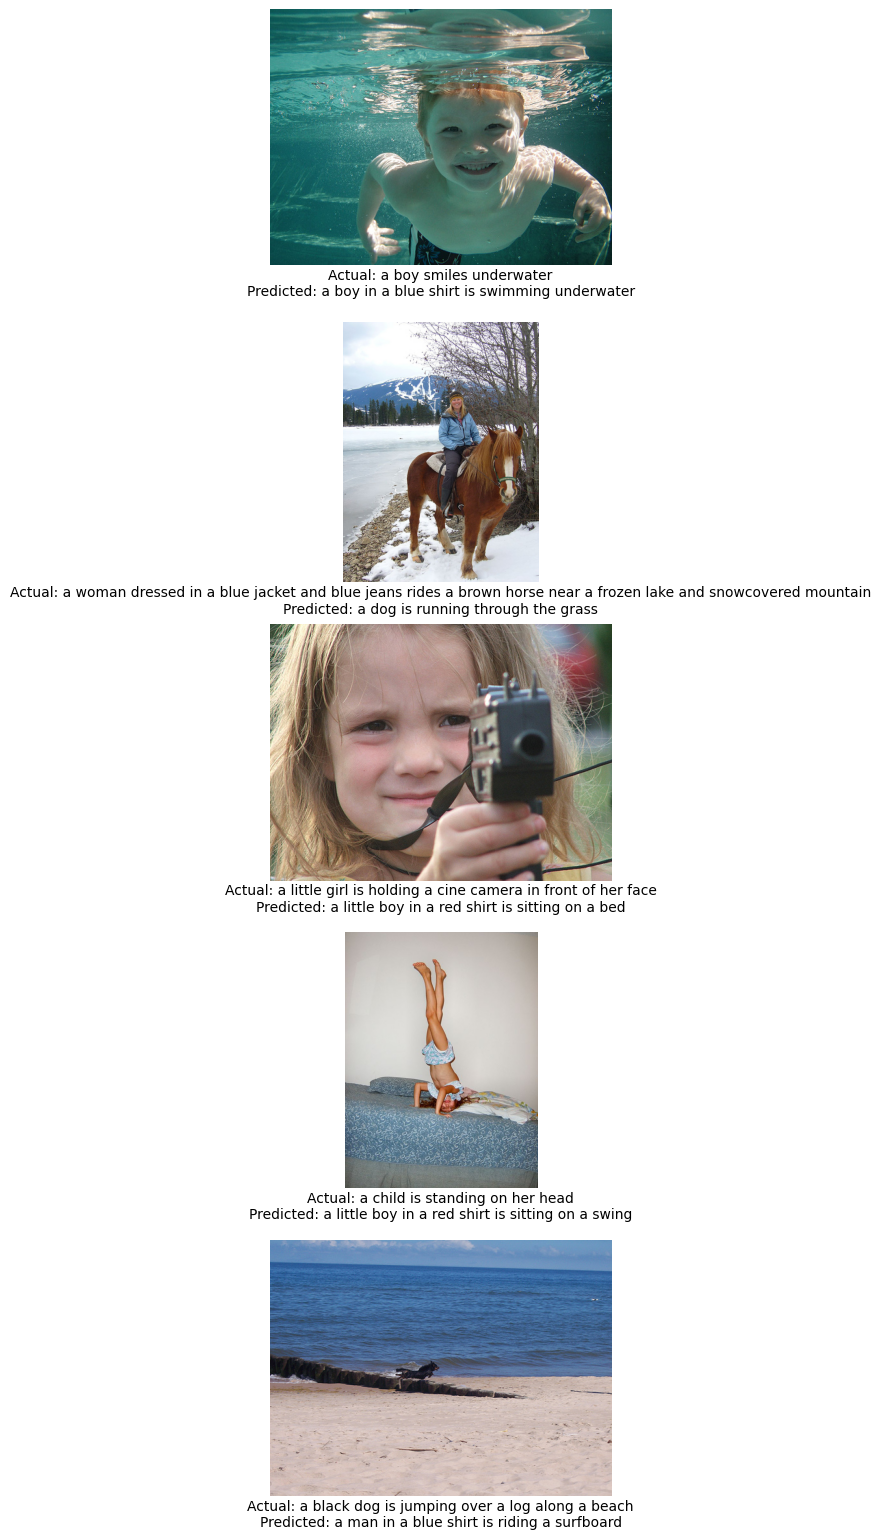

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
p = 0
i = -1
plt.figure(figsize=(255, 255))
for key, caption in test_captions.items():
  img_path = '/content/drive/My Drive/archive/Images/' + key
  img = Image.open(img_path)
  act_cap = " ".join(actual[p][0])
  pred_cap = " ".join(pred[p])
  plt.subplot(len(img_path), 1, p+1)
  # plt.subplot(p+1, len(img_path), 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Actual: {act_cap}\nPredicted: {pred_cap}", fontsize=10, y=-0.15)
  p = p+1
  if(p == 5):
    break
